# Movie Studio Analysis: Understanding Box Office Success
## Business Understanding
The company is planning to launch a new movie studio, but lacks experience in movie production. The goal of this analysis is to explore current trends in the film industry and provide actionable insights that can guide the studio's strategy. This analysis focuses on identifying factors that contribute to box office success, including genre, budget, release timing, and the impact of key personnel such as directors, actors, and writers.
    

## Data Understanding
The analysis is based on multiple datasets related to movie budgets, revenues, genres, release dates, and key personnel (directors, actors, and writers).

These datasets include:
   - **Box Office Mojo (BOM) Movie Gross**: Contains information on domestic and foreign box office revenues.
   - **TMDB Movies**: Includes information on movie popularity and ratings.
   - **IMDb Database**: Provides detailed information on directors, actors, writers, and other key personnel involved in the movies.
 
**Note** See `eda.py` for a more robust data understanding
    

## Data Preparation
In this section, we will load, clean, and merge the datasets to prepare them for analysis.

### Loading

In [90]:
# Library imports
import pandas as pd
import sqlite3
from zipfile import ZipFile
import scipy.stats as stats
import helper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [91]:
# Load the datasets
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tn_movies = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

In [92]:
# Loading IMDb SQLite database

# Unzip the sqlite db file if not already done
with ZipFile("zippedData/im.db.zip", 'r') as zObject:
    zObject.extractall("zippedData/")

# Creating the connection
conn = sqlite3.connect("zippedData/im.db")

# Loading data for directors, actors, and writers filtering for US movies in English

# Queries
query_directors = """
SELECT mb.*, mr.averagerating, mr.numvotes, p.primary_name, p.birth_year, p.death_year, p.primary_profession
FROM movie_basics AS mb
JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
JOIN principals AS pr ON mb.movie_id = pr.movie_id
JOIN persons AS p ON pr.person_id = p.person_id
JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id
WHERE ma.region = 'US'
AND pr.category = 'director'
AND ma.language = 'en';
"""

query_actors = """
SELECT mb.*, mr.averagerating, mr.numvotes, p.primary_name, p.birth_year, p.death_year, p.primary_profession
FROM movie_basics AS mb
JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
JOIN principals AS pr ON mb.movie_id = pr.movie_id
JOIN persons AS p ON pr.person_id = p.person_id
JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id
WHERE ma.region = 'US'
AND pr.category = 'actor'
AND ma.language = 'en';
"""

query_writers = """
SELECT mb.*, mr.averagerating, mr.numvotes, p.primary_name, p.birth_year, p.death_year, p.primary_profession
FROM movie_basics AS mb
JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
JOIN principals AS pr ON mb.movie_id = pr.movie_id
JOIN persons AS p ON pr.person_id = p.person_id
JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id
WHERE ma.region = 'US'
AND pr.category = 'writer'
AND ma.language = 'en';
"""

query_basics = """
SELECT *
FROM movie_basics
"""

query_ratings = """
SELECT *
FROM movie_ratings
"""

# Execute queries and assign to dataframes
directors_merged = pd.read_sql_query(query_directors, conn)
actors_merged = pd.read_sql_query(query_actors, conn)
writers_merged = pd.read_sql_query(query_writers, conn)
movie_basics = pd.read_sql_query(query_basics, conn)
movie_ratings = pd.read_sql_query(query_ratings, conn)

# Close the connection
conn.close()

### Cleaning

In [93]:
# Cleaning IMDb data

directors_cleaned = helper.clean_imdb_data(directors_merged)
actors_cleaned = helper.clean_imdb_data(actors_merged)
writers_cleaned = helper.clean_imdb_data(writers_merged)

# Extracting the primary genre from the 'genres' column
movie_basics['primary_genre'] = movie_basics['genres'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else None)

In [94]:
# Cleaning TMDB data
tmdb_cleaned = helper.clean_tmdb_data(tmdb_movies)

In [95]:
# Cleaning 'The Numbers' movie budgets data

tn_movie_budgets_cleaned = helper.clean_tn_movie_budgets(tn_movies)

In [154]:
# Merge TMDB and TN Movie Budgets data
merged_data = pd.merge(tmdb_cleaned, tn_movie_budgets_cleaned, left_on='title', right_on='movie')

# Dropping duplicates based on 'title' and 'release_date'
if 'release_date_x' in merged_data.columns:
    merged_data = merged_data.drop_duplicates(subset=['title', 'release_date_x'])
    print("Dropped duplicates based on 'title' and 'release_date'.")
else:
    print("Error: 'release_date' column is missing in the merged data.")
    
# Merging IMDb data
# Ensuring correct data types
movie_basics['primary_title'] = movie_basics['primary_title'].astype(str)
merged_data['title'] = merged_data['title'].astype(str)

# Merge the primary genre from IMDb into the merged_data DataFrame
merged_data = pd.merge(merged_data, movie_basics[['primary_title', 'primary_genre']], left_on='title', right_on='primary_title', how='left')

# Drop the extra 'primary_title' column after merging
merged_data = merged_data.drop(columns=['primary_title'])

Dropped duplicates based on 'title' and 'release_date'.


### Feature Engineering

In [97]:
# Adding in ROI columns
merged_data['roi_domestic'] = merged_data['domestic_gross'] / merged_data['production_budget']
merged_data['roi_worldwide'] = merged_data['worldwide_gross'] / merged_data['production_budget']

In [98]:
# Extract the month from 'release_date_x' and create a new 'month' column
merged_data['month'] = merged_data['release_date_x'].dt.month

In [99]:
# Drop duplicates based on 'title' and 'release_date'
merged_data = merged_data.drop_duplicates(subset=['title', 'release_date_x'])

In [101]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2124 entries, 0 to 4420
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         2124 non-null   int64         
 1   genre_ids          2124 non-null   object        
 2   id_x               2124 non-null   int64         
 3   original_language  2124 non-null   object        
 4   original_title     2124 non-null   object        
 5   popularity         2124 non-null   float64       
 6   release_date_x     2124 non-null   datetime64[ns]
 7   title              2124 non-null   object        
 8   vote_average       2124 non-null   float64       
 9   vote_count         2124 non-null   int64         
 10  id_y               2124 non-null   int64         
 11  release_date_y     2124 non-null   datetime64[ns]
 12  movie              2124 non-null   object        
 13  production_budget  2124 non-null   float64       
 14  domestic_gros

In [102]:
# Looks like many of the genre values are missing. TMDB provides an API we can use to fill these in.
merged_data = helper.update_missing_genres(merged_data)

Updating missing genres: 100%|██████████| 151/151 [00:18<00:00,  8.04it/s]


In [103]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2124 entries, 0 to 4420
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         2124 non-null   int64         
 1   genre_ids          2124 non-null   object        
 2   id_x               2124 non-null   int64         
 3   original_language  2124 non-null   object        
 4   original_title     2124 non-null   object        
 5   popularity         2124 non-null   float64       
 6   release_date_x     2124 non-null   datetime64[ns]
 7   title              2124 non-null   object        
 8   vote_average       2124 non-null   float64       
 9   vote_count         2124 non-null   int64         
 10  id_y               2124 non-null   int64         
 11  release_date_y     2124 non-null   datetime64[ns]
 12  movie              2124 non-null   object        
 13  production_budget  2124 non-null   float64       
 14  domestic_gros

In [104]:
# We were able to get genres for all but 10 of the movies, so I will drop those that are missing
merged_data = merged_data.dropna(subset=['primary_genre'])

In [105]:
# I would also like to take a look at movies that belong to a franchise to see if they perform differently than those that are 'one-offs'

# Initialize the 'franchise' and 'collection' columns
merged_data['franchise'] = False
merged_data['collection'] = None

# Update the franchise info for all movies
merged_data = helper.update_franchise_info(merged_data)

Updating franchise info: 100%|██████████| 2114/2114 [03:43<00:00,  9.44it/s]


In [ ]:
# Drop the redundant columns
columns_to_drop = ['Unnamed: 0', 'genre_ids', 'original_title', 'id_y', 'release_date_y', 'movie']
merged_data_cleaned = merged_data.drop(columns=columns_to_drop)

# Rename columns as specified
merged_data_cleaned = merged_data_cleaned.rename(columns={'id_x': 'tmdb_id', 'release_date_x': 'release_date', 'month': 'release_month'})

In [106]:
# Preview the updated DataFrame
merged_data_cleaned.head()

,tmdb_id,original_language,popularity,release_date,title,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,primary_genre,roi_domestic,roi_worldwide,release_month,franchise,collection
0,10191,en,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,165000000.0,217581232.0,494870992.0,Action,1.318674,2.999218,3,True,How to Train Your Dragon Collection
1,10138,en,28.515,2010-05-07,Iron Man 2,6.8,12368,170000000.0,312433331.0,621156389.0,Action,1.837843,3.653861,5,True,Iron Man Collection
2,862,en,28.005,1995-11-22,Toy Story,7.9,10174,30000000.0,191796233.0,364545516.0,Animation,6.393208,12.151517,11,True,Toy Story Collection
3,27205,en,27.920,2010-07-16,Inception,8.3,22186,160000000.0,292576195.0,835524642.0,Action,1.828601,5.222029,7,False,None
4,32657,en,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,95000000.0,88768303.0,223050874.0,Adventure,0.934403,2.347904,2,True,Percy Jackson Collection


## Modeling
Here we will perform various statistical analyses via hypothesis testing, and linear regreassion modeling

In [155]:
# Does genre significantly impact ROI?

# H0 - Genre does not impact ROI
# H1 - Genre does impact ROI

# Domestic ROI

# Drop missing values for the relevant columns
genre_roi_data = merged_data_cleaned.dropna(subset=['primary_genre', 'roi_domestic', 'roi_worldwide'])

# Group by primary genre and calculate the mean revenue for each genre
genre_roi = genre_roi_data.groupby('primary_genre')['roi_domestic'].mean()

# Perform ANOVA to test if the means are significantly different
anova_results = stats.f_oneway(*[genre_roi_data[genre_roi_data['primary_genre'] == genre]['roi_domestic']
                                 for genre in genre_roi.index])

# Output the ANOVA results
print("ANOVA Results for Genre Impact on Worldwide ROI:")
print(f"F-statistic: {anova_results.statistic}, p-value: {anova_results.pvalue}")

# Interpretation
if anova_results.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in domestic ROI across genres.\n")
else:
    print("Fail to reject the null hypothesis: No significant difference in domestic ROI across genres.\n")
    
# Worldwide ROI

# Group by primary genre and calculate the mean revenue for each genre
genre_roi = genre_roi_data.groupby('primary_genre')['roi_worldwide'].mean()

# Perform ANOVA to test if the means are significantly different
anova_results = stats.f_oneway(*[genre_roi_data[genre_roi_data['primary_genre'] == genre]['roi_worldwide']
                                 for genre in genre_roi.index])

# Output the ANOVA results
print("ANOVA Results for Genre Impact on Worldwide ROI:")
print(f"F-statistic: {anova_results.statistic}, p-value: {anova_results.pvalue}")

# Interpretation
if anova_results.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in worldwide ROI across genres.")
else:
    print("Fail to reject the null hypothesis: No significant difference in worldwide ROI across genres.")
    
    

ANOVA Results for Genre Impact on Worldwide ROI:
F-statistic: 3.6299154011564334, p-value: 5.016404509540143e-08
Reject the null hypothesis: There is a significant difference in domestic ROI across genres.

ANOVA Results for Genre Impact on Worldwide ROI:
F-statistic: 4.249328207795131, p-value: 3.88690241691565e-10
Reject the null hypothesis: There is a significant difference in worldwide ROI across genres.


In [156]:
# Does being in a franchise impact ROI?

# H0 - There is no difference in the average worldwide gross revenue between franchise and non-franchise movies.
# H1 - There is a difference in the average worldwide gross revenue between franchise and non-franchise movies.

# Split the data into two groups: franchise and non-franchise for worldwide ROI
ww_franchise_movies = merged_data_cleaned[merged_data_cleaned['franchise'] == True]['roi_worldwide']
ww_non_franchise_movies = merged_data_cleaned[merged_data_cleaned['franchise'] == False]['roi_worldwide']

# Perform a t-test for worldwide ROI
ww_t_stat, ww_p_value = stats.ttest_ind(ww_franchise_movies.dropna(), ww_non_franchise_movies.dropna(), equal_var=False)

print("T-Test Results for Franchise Impact on Worldwide ROI:")
print(f"T-statistic: {ww_t_stat}, p-value: {ww_p_value}")

if ww_p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in worldwide ROI for movies in a franchise.\n")
else:
    print("Fail to reject the null hypothesis: There is NOT a significant difference in worldwide ROI for movies in a franchise.\n")
    
# Split the data into two groups: franchise and non-franchise for domestic ROI
d_franchise_movies = merged_data_cleaned[merged_data_cleaned['franchise'] == True]['roi_domestic']
d_non_franchise_movies = merged_data_cleaned[merged_data_cleaned['franchise'] == False]['roi_domestic']

# Perform a t-test for domestic ROI
d_t_stat, d_p_value = stats.ttest_ind(d_franchise_movies.dropna(), d_non_franchise_movies.dropna(), equal_var=False)

print("T-Test Results for Franchise Impact on Domestic ROI:")
print(f"T-statistic: {d_t_stat}, p-value: {d_p_value}")

if d_p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in domestic ROI for movies in a franchise.")
else:
    print("Fail to reject the null hypothesis: There is NOT a significant difference in domestic ROI for movies in a franchise.")

T-Test Results for Franchise Impact on Worldwide ROI:
T-statistic: 3.797323557634855, p-value: 0.0001689329659322775
Reject the null hypothesis: There is a significant difference in worldwide ROI for movies in a franchise.

T-Test Results for Franchise Impact on Domestic ROI:
T-statistic: 2.9288433848764943, p-value: 0.0035936269884244403
Reject the null hypothesis: There is a significant difference in domestic ROI for movies in a franchise.


In [157]:
# Does the time of year the movie is released in matter?

# H0 - There is no significant difference in ROI based on which month the movie is released
# H1 - There is a significant difference in ROI based on which month the movie is released

# Group the data by release month for worldwide ROI
ww_monthly_roi = merged_data_cleaned.groupby('release_month')['roi_worldwide'].apply(list)

# Perform the ANOVA test
ww_anova_result = stats.f_oneway(*[roi for roi in ww_monthly_roi])

# Output the ANOVA results
print("ANOVA Results for Release Month Impact on Worldwide ROI:")
print(f"F-statistic: {ww_anova_result.statistic}, p-value: {ww_anova_result.pvalue}")

# Interpretation
if ww_anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in worldwide ROI across release month.\n")
else:
    print("Fail to reject the null hypothesis: No significant difference in worldwide ROI across release month.\n")

# Group the data by release month for domestic ROI
d_monthly_roi = merged_data_cleaned.groupby('release_month')['roi_domestic'].apply(list)

# Perform the ANOVA test
d_anova_result = stats.f_oneway(*[roi for roi in d_monthly_roi])

# Output the ANOVA results
print("ANOVA Results for Release Month Impact on Domestic ROI:")
print(f"F-statistic: {d_anova_result.statistic}, p-value: {d_anova_result.pvalue}")

# Interpretation
if d_anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in domestic ROI across release month.")
else:
    print("Fail to reject the null hypothesis: No significant difference in domestic ROI across release month.")


ANOVA Results for Release Month Impact on Worldwide ROI:
F-statistic: 1.4252451648435245, p-value: 0.15451297079742496
Fail to reject the null hypothesis: No significant difference in worldwide ROI across release month.

ANOVA Results for Release Month Impact on Domestic ROI:
F-statistic: 1.1625733712012765, p-value: 0.3081616903528722
Fail to reject the null hypothesis: No significant difference in domestic ROI across release month.


In [110]:
# Does production budget impact ROI or Gross?

# H0a - Production budget does not have a significant impact on ROI
# H1a - Production budget has a significant impact on ROI
# H0b - Production budget does not have a significant impact on gross
# H1b - Production budget has a significant impact on gross

# Linear regression for domestic ROI
slope_dom_roi, intercept_dom_roi, r_value_dom_roi, p_value_dom_roi, std_err_dom_roi = stats.linregress(
    merged_data_cleaned['production_budget'], merged_data_cleaned['roi_domestic'])

print(f"Domestic ROI Regression Results:")
print(f"Slope: {slope_dom_roi}")
print(f"Intercept: {intercept_dom_roi}")
print(f"R-squared: {r_value_dom_roi**2}")
print(f"P-value: {p_value_dom_roi}\n")

# Linear regression for domestic gross
slope_dom_gross, intercept_dom_gross, r_value_dom_gross, p_value_dom_gross, std_err_dom_gross = stats.linregress(
    merged_data_cleaned['production_budget'], merged_data_cleaned['domestic_gross'])

print(f"Domestic Gross Regression Results:")
print(f"Slope: {slope_dom_gross}")
print(f"Intercept: {intercept_dom_gross}")
print(f"R-squared: {r_value_dom_gross**2}")
print(f"P-value: {p_value_dom_gross}\n")

# Linear regression for worldwide ROI
slope_world_roi, intercept_world_roi, r_value_world_roi, p_value_world_roi, std_err_world_roi = stats.linregress(
    merged_data_cleaned['production_budget'], merged_data_cleaned['roi_worldwide'])

print(f"Worldwide ROI Regression Results:")
print(f"Slope: {slope_world_roi}")
print(f"Intercept: {intercept_world_roi}")
print(f"R-squared: {r_value_world_roi**2}")
print(f"P-value: {p_value_world_roi}\n")

# Linear regression for worldwide gross
slope_world_gross, intercept_world_gross, r_value_world_gross, p_value_world_gross, std_err_world_gross = stats.linregress(
    merged_data_cleaned['production_budget'], merged_data_cleaned['worldwide_gross'])

print(f"Worldwide Gross Regression Results:")
print(f"Slope: {slope_world_gross}")
print(f"Intercept: {intercept_world_gross}")
print(f"R-squared: {r_value_world_gross**2}")
print(f"P-value: {p_value_world_gross}\n")

Domestic ROI Regression Results:
Slope: -9.622155887079312e-09
Intercept: 2.3242254344926367
R-squared: 0.005510687712702002
P-value: 0.0006358440802301604

Domestic Gross Regression Results:
Slope: 1.169715934925598
Intercept: 4353189.260108948
R-squared: 0.5370973593379069
P-value: 0.0

Worldwide ROI Regression Results:
Slope: -7.86202850726377e-09
Intercept: 3.9838429163431135
R-squared: 0.001266393693980641
P-value: 0.10189147507521298

Worldwide Gross Regression Results:
Slope: 3.467976689697516
Intercept: -12830191.121621355
R-squared: 0.6386219655522728
P-value: 0.0



In [111]:
# Step 1: Merge IMDb data (directors, actors, writers) with the merged_data_cleaned
# First, merge directors_cleaned with merged_data_cleaned using the movie title
directors_merged = pd.merge(directors_cleaned, merged_data_cleaned, left_on='primary_title', right_on='title', how='inner')
actors_merged = pd.merge(actors_cleaned, merged_data_cleaned, left_on='primary_title', right_on='title', how='inner')
writers_merged = pd.merge(writers_cleaned, merged_data_cleaned, left_on='primary_title', right_on='title', how='inner')

# Step 2: Clean up merged data (drop unnecessary columns)
directors_merged = directors_merged[['primary_name', 'title', 'production_budget', 'domestic_gross', 'worldwide_gross', 'roi_domestic', 'roi_worldwide']]
actors_merged = actors_merged[['primary_name', 'title', 'production_budget', 'domestic_gross', 'worldwide_gross', 'roi_domestic', 'roi_worldwide']]
writers_merged = writers_merged[['primary_name', 'title', 'production_budget', 'domestic_gross', 'worldwide_gross', 'roi_domestic', 'roi_worldwide']]

# Step 3: Calculate ROI for each director, actor, and writer
# Group by primary_name (which represents directors, actors, or writers) and calculate the average ROI

# Directors
director_roi = directors_merged.groupby('primary_name').agg({
    'roi_domestic': 'mean',
    'roi_worldwide': 'mean'
}).reset_index()

# Actors
actor_roi = actors_merged.groupby('primary_name').agg({
    'roi_domestic': 'mean',
    'roi_worldwide': 'mean'
}).reset_index()

# Writers
writer_roi = writers_merged.groupby('primary_name').agg({
    'roi_domestic': 'mean',
    'roi_worldwide': 'mean'
}).reset_index()

# Step 4: Get the top 100 directors, actors, and writers based on frequency in the dataset
top_100_directors = directors_merged['primary_name'].value_counts().head(100).index
top_100_actors = actors_merged['primary_name'].value_counts().head(100).index
top_100_writers = writers_merged['primary_name'].value_counts().head(100).index

# Step 5: Filter the data for the top 100 of each
top_directors_data = directors_merged[directors_merged['primary_name'].isin(top_100_directors)]
top_actors_data = actors_merged[actors_merged['primary_name'].isin(top_100_actors)]
top_writers_data = writers_merged[writers_merged['primary_name'].isin(top_100_writers)]

# Test
# Winsorize the ROI data to limit the impact of extreme values
top_directors_data['roi_domestic_winsorized'] = stats.mstats.winsorize(top_directors_data['roi_domestic'], limits=[0.05, 0.05])
top_actors_data['roi_domestic_winsorized'] = stats.mstats.winsorize(top_actors_data['roi_domestic'], limits=[0.05, 0.05])
top_writers_data['roi_domestic_winsorized'] = stats.mstats.winsorize(top_writers_data['roi_domestic'], limits=[0.05, 0.05])

# Winsorize the ROI data to limit the impact of extreme values (Using .loc to avoid warnings)
top_directors_data.loc[:, 'roi_domestic_winsorized'] = stats.mstats.winsorize(top_directors_data['roi_domestic'], limits=[0.05, 0.05])
top_actors_data.loc[:, 'roi_domestic_winsorized'] = stats.mstats.winsorize(top_actors_data['roi_domestic'], limits=[0.05, 0.05])
top_writers_data.loc[:, 'roi_domestic_winsorized'] = stats.mstats.winsorize(top_writers_data['roi_domestic'], limits=[0.05, 0.05])

top_directors_data.loc[:, 'roi_worldwide_winsorized'] = stats.mstats.winsorize(top_directors_data['roi_worldwide'], limits=[0.05, 0.05])
top_actors_data.loc[:, 'roi_worldwide_winsorized'] = stats.mstats.winsorize(top_actors_data['roi_worldwide'], limits=[0.05, 0.05])
top_writers_data.loc[:, 'roi_worldwide_winsorized'] = stats.mstats.winsorize(top_writers_data['roi_worldwide'], limits=[0.05, 0.05])

# Step 6: Perform ANOVA to test for significant differences in ROI

# Domestic ROI - Directors
anova_directors_domestic = stats.f_oneway(*[top_directors_data[top_directors_data['primary_name'] == name]['roi_domestic_winsorized'].dropna()
                                            for name in top_100_directors])
# Worldwide ROI - Directors
anova_directors_worldwide = stats.f_oneway(*[top_directors_data[top_directors_data['primary_name'] == name]['roi_worldwide_winsorized'].dropna()
                                             for name in top_100_directors])

# Domestic ROI - Actors
anova_actors_domestic = stats.f_oneway(*[top_actors_data[top_actors_data['primary_name'] == name]['roi_domestic_winsorized'].dropna()
                                         for name in top_100_actors])
# Worldwide ROI - Actors
anova_actors_worldwide = stats.f_oneway(*[top_actors_data[top_actors_data['primary_name'] == name]['roi_worldwide_winsorized'].dropna()
                                          for name in top_100_actors])

# Domestic ROI - Writers
anova_writers_domestic = stats.f_oneway(*[top_writers_data[top_writers_data['primary_name'] == name]['roi_domestic_winsorized'].dropna()
                                          for name in top_100_writers])
# Worldwide ROI - Writers
anova_writers_worldwide = stats.f_oneway(*[top_writers_data[top_writers_data['primary_name'] == name]['roi_worldwide_winsorized'].dropna()
                                           for name in top_100_writers])

# Step 7: Output the results
print("ANOVA Results for Directors' Domestic ROI:", anova_directors_domestic)
print("ANOVA Results for Directors' Worldwide ROI:", anova_directors_worldwide)

print("ANOVA Results for Actors' Domestic ROI:", anova_actors_domestic)
print("ANOVA Results for Actors' Worldwide ROI:", anova_actors_worldwide)

print("ANOVA Results for Writers' Domestic ROI:", anova_writers_domestic)
print("ANOVA Results for Writers' Worldwide ROI:", anova_writers_worldwide)


ANOVA Results for Directors' Domestic ROI: F_onewayResult(statistic=2.587446894329909, pvalue=0.06354309165275934)
ANOVA Results for Directors' Worldwide ROI: F_onewayResult(statistic=7.445813622655221, pvalue=0.0014916919278293258)
ANOVA Results for Actors' Domestic ROI: F_onewayResult(statistic=2.6242737022450204, pvalue=0.005872571429145447)
ANOVA Results for Actors' Worldwide ROI: F_onewayResult(statistic=2.3540243817546456, pvalue=0.012046431253782387)
ANOVA Results for Writers' Domestic ROI: F_onewayResult(statistic=3.3812387209287644, pvalue=0.00037650168674166224)
ANOVA Results for Writers' Worldwide ROI: F_onewayResult(statistic=4.981332967602058, pvalue=9.291885330752434e-06)


## Evaluation

### 1. Genre Impact on ROI

- **ANOVA Results for Domestic ROI:**
  - **F-statistic**: 3.630
  - **P-value**: 5.02e-08
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **domestic ROI** across genres.
  
- **ANOVA Results for Worldwide ROI:**
  - **F-statistic**: 4.249
  - **P-value**: 3.89e-10
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **worldwide ROI** across genres.

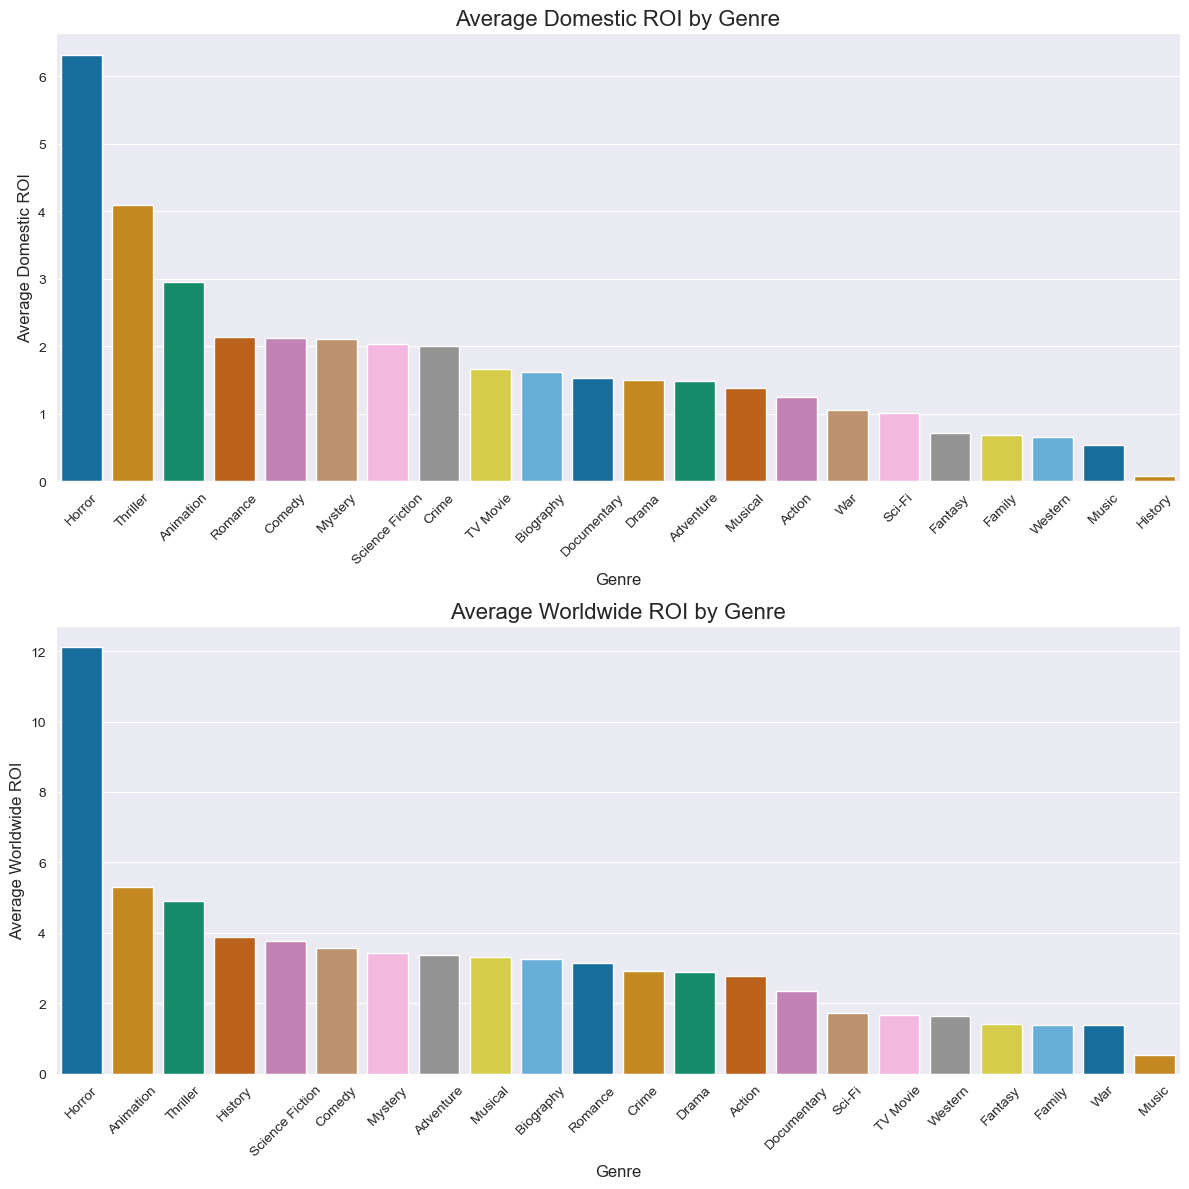

In [158]:
# Set a colorblind-friendly palette
palette = sns.color_palette('colorblind', n_colors=len(merged_data_cleaned['primary_genre'].unique()))

# Create a figure with 2 subplots: one for Domestic ROI, one for Worldwide ROI
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Group the data by primary genre and calculate the mean Domestic ROI
genre_domestic_roi = merged_data_cleaned.groupby('primary_genre')['roi_domestic'].mean().dropna().sort_values(ascending=False)

# Plot the bar chart for Domestic ROI by Genre
sns.barplot(x=genre_domestic_roi.index, y=genre_domestic_roi.values, ax=axes[0], palette=palette)

# Customize the Domestic ROI plot
axes[0].set_title('Average Domestic ROI by Genre', fontsize=16)
axes[0].set_xlabel('Genre', fontsize=12)
axes[0].set_ylabel('Average Domestic ROI', fontsize=12)

# Rotate x-axis labels for readability in the Domestic ROI chart
axes[0].tick_params(axis='x', rotation=45)

# Group the data by primary genre and calculate the mean Worldwide ROI
genre_worldwide_roi = merged_data_cleaned.groupby('primary_genre')['roi_worldwide'].mean().dropna().sort_values(ascending=False)

# Plot the bar chart for Worldwide ROI by Genre
sns.barplot(x=genre_worldwide_roi.index, y=genre_worldwide_roi.values, ax=axes[1], palette=palette)

# Customize the Worldwide ROI plot
axes[1].set_title('Average Worldwide ROI by Genre', fontsize=16)
axes[1].set_xlabel('Genre', fontsize=12)
axes[1].set_ylabel('Average Worldwide ROI', fontsize=12)

# Rotate x-axis labels for readability in the Worldwide ROI chart
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to fit the labels
plt.tight_layout()

# Show the combined plots
plt.show()


### 2. Franchise Impact on ROI

- **T-Test Results for Franchise Impact on Domestic ROI:**
  - **T-statistic**: 2.929
  - **P-value**: 0.0036
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **domestic ROI** for movies in a franchise vs. those not in a franchise.
  
- **T-Test Results for Franchise Impact on Worldwide ROI:**
  - **T-statistic**: 3.797
  - **P-value**: 0.00017
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **worldwide ROI** for movies in a franchise vs. those not in a franchise.

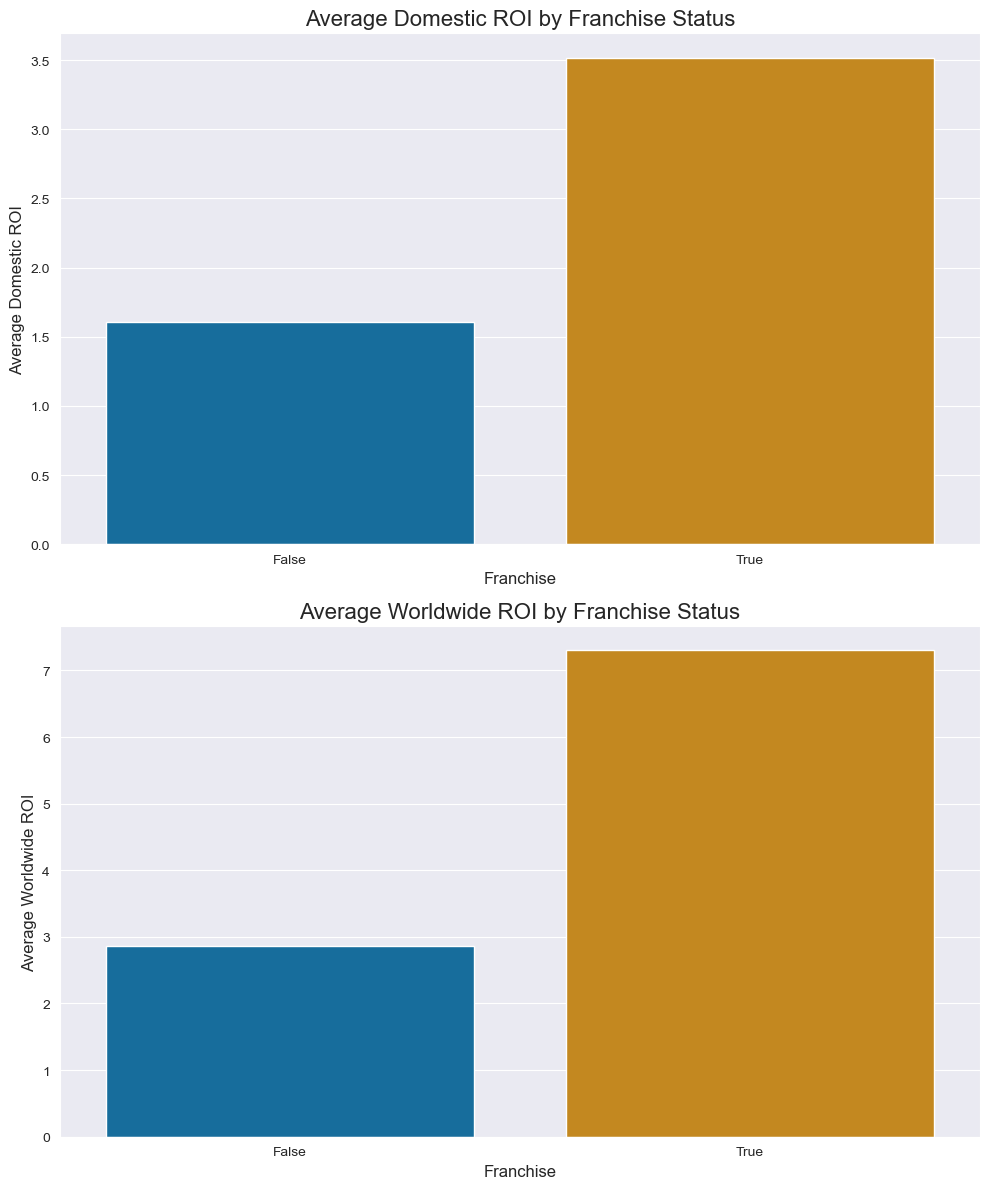

In [159]:
# Set a colorblind-friendly palette
palette = sns.color_palette('colorblind', n_colors=len(merged_data_cleaned['franchise'].unique()))

# Create a figure with 2 subplots: one for Domestic ROI, one for Worldwide ROI
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Group the data by franchise and calculate the mean Domestic ROI
franchise_domestic_roi = merged_data_cleaned.groupby('franchise')['roi_domestic'].mean().dropna()

# Plot the bar chart for Domestic ROI by Franchise Status
sns.barplot(x=franchise_domestic_roi.index, y=franchise_domestic_roi.values, ax=axes[0], palette=palette)

# Customize the Domestic ROI plot
axes[0].set_title('Average Domestic ROI by Franchise Status', fontsize=16)
axes[0].set_xlabel('Franchise', fontsize=12)
axes[0].set_ylabel('Average Domestic ROI', fontsize=12)

# Group the data by franchise and calculate the mean Worldwide ROI
franchise_worldwide_roi = merged_data_cleaned.groupby('franchise')['roi_worldwide'].mean().dropna()

# Plot the bar chart for Worldwide ROI by Franchise Status
sns.barplot(x=franchise_worldwide_roi.index, y=franchise_worldwide_roi.values, ax=axes[1], palette=palette)

# Customize the Worldwide ROI plot
axes[1].set_title('Average Worldwide ROI by Franchise Status', fontsize=16)
axes[1].set_xlabel('Franchise', fontsize=12)
axes[1].set_ylabel('Average Worldwide ROI', fontsize=12)

# Adjust layout to fit the labels
plt.tight_layout()

# Show the combined plots
plt.show()


### 3. Release Month Impact on ROI

- **ANOVA Results for Domestic ROI:**
  - **F-statistic**: 1.163
  - **P-value**: 0.3082
  - **Conclusion**: We **fail to reject the null hypothesis**. There is **no significant difference** in **domestic ROI** across release months.
  
- **ANOVA Results for Worldwide ROI:**
  - **F-statistic**: 1.425
  - **P-value**: 0.1545
  - **Conclusion**: We **fail to reject the null hypothesis**. There is **no significant difference** in **worldwide ROI** across release months.

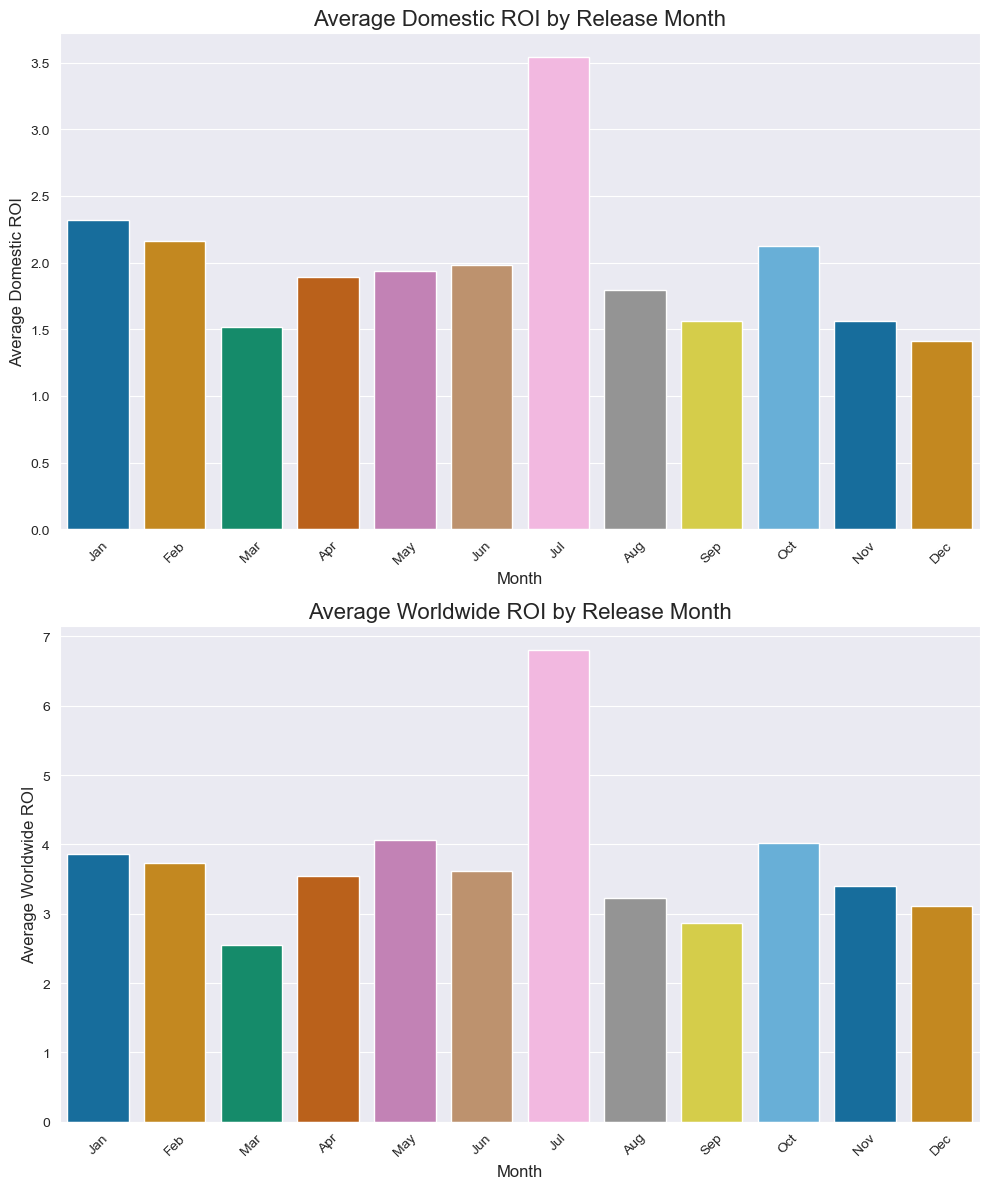

In [160]:
# Create a colorblind-friendly palette for the 12 months
palette = sns.color_palette('colorblind', n_colors=12)

# Create a figure with 2 subplots: one for Domestic ROI and one for Worldwide ROI
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Group the data by release month and calculate the mean Domestic ROI
release_month_domestic_roi = merged_data_cleaned.groupby('release_month')['roi_domestic'].mean().dropna()

# Plot the bar chart for Domestic ROI by Release Month
sns.barplot(x=release_month_domestic_roi.index, y=release_month_domestic_roi.values, ax=axes[0], palette=palette)

# Customize the Domestic ROI plot
axes[0].set_title('Average Domestic ROI by Release Month', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average Domestic ROI', fontsize=12)
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Group the data by release month and calculate the mean Worldwide ROI
release_month_worldwide_roi = merged_data_cleaned.groupby('release_month')['roi_worldwide'].mean().dropna()

# Plot the bar chart for Worldwide ROI by Release Month
sns.barplot(x=release_month_worldwide_roi.index, y=release_month_worldwide_roi.values, ax=axes[1], palette=palette)

# Customize the Worldwide ROI plot
axes[1].set_title('Average Worldwide ROI by Release Month', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Average Worldwide ROI', fontsize=12)
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Adjust layout to fit the labels
plt.tight_layout()

# Show the combined plots
plt.show()


### 4. Impact of Production Budget on ROI and Gross Revenue

- **Domestic ROI Regression Results:**
  - **Slope**: -9.62e-09
  - **Intercept**: 2.324
  - **R-squared**: 0.0055
  - **P-value**: 0.0006
  - **Conclusion**: There is a very small **negative correlation** between **production budget** and **domestic ROI**, but the effect size is minimal.

- **Domestic Gross Regression Results:**
  - **Slope**: 1.170
  - **Intercept**: 4,353,189
  - **R-squared**: 0.537
  - **P-value**: 0.0
  - **Conclusion**: There is a **positive and significant correlation** between **production budget** and **domestic gross revenue**.

- **Worldwide ROI Regression Results:**
  - **Slope**: -7.86e-09
  - **Intercept**: 3.984
  - **R-squared**: 0.0013
  - **P-value**: 0.1019
  - **Conclusion**: There is no significant relationship between **production budget** and **worldwide ROI**.

- **Worldwide Gross Regression Results:**
  - **Slope**: 3.468
  - **Intercept**: -12,830,191
  - **R-squared**: 0.639
  - **P-value**: 0.0
  - **Conclusion**: There is a **strong positive correlation** between **production budget** and **worldwide gross revenue**.

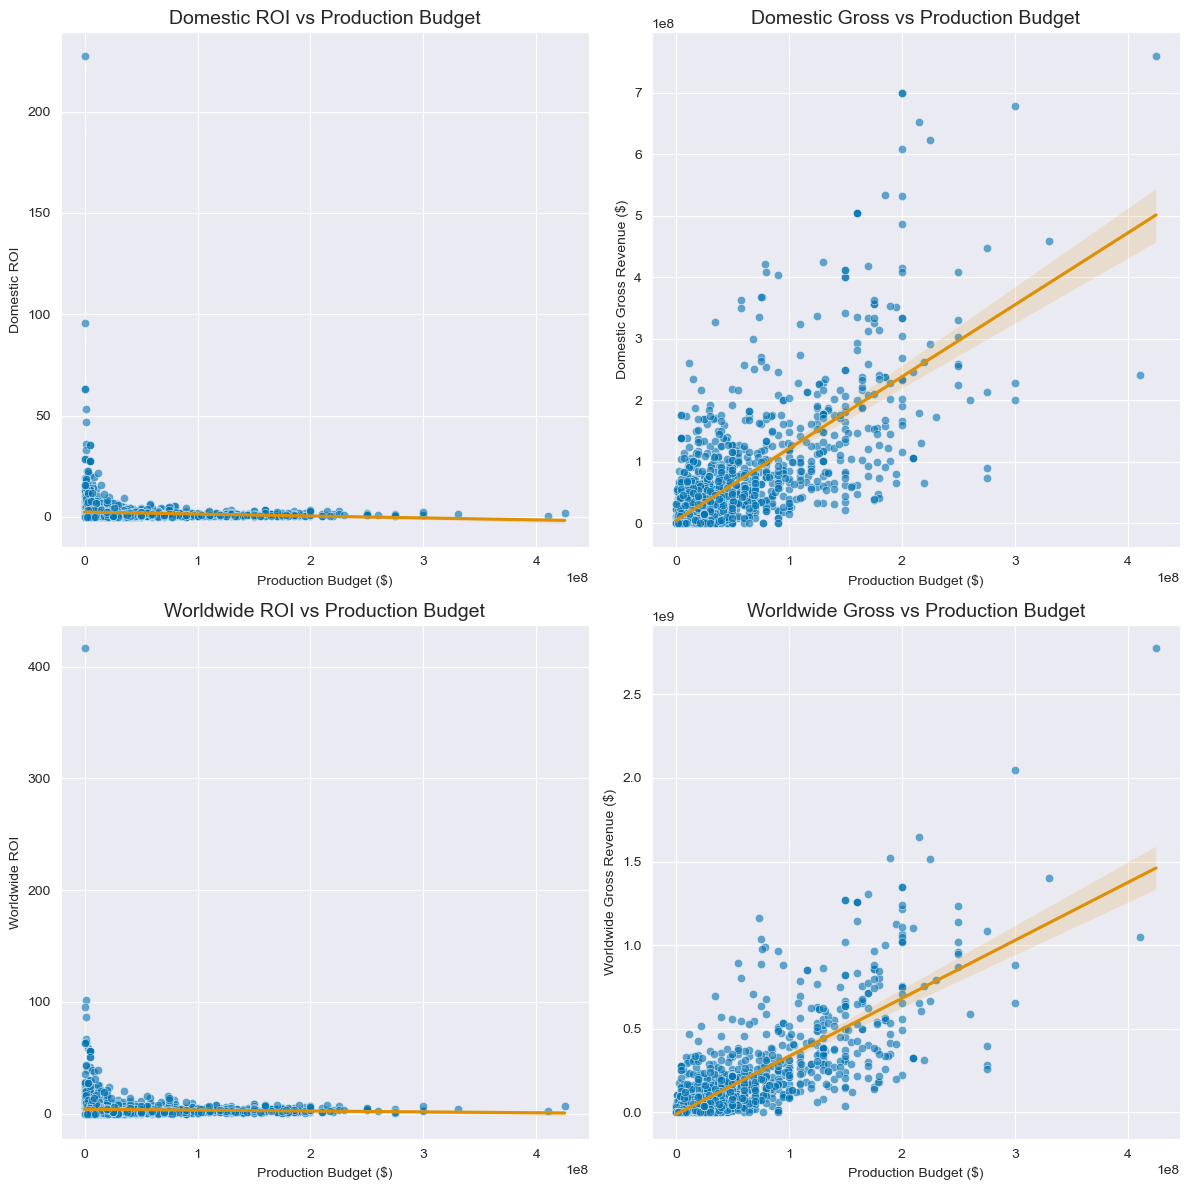

In [162]:
# Set a colorblind-friendly palette
sns.set_palette('colorblind')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Adjust the layout to prevent overlap
plt.tight_layout(pad=5.0)

# Domestic ROI vs Production Budget
sns.scatterplot(x=merged_data_cleaned['production_budget'], y=merged_data_cleaned['roi_domestic'],
                alpha=0.6, ax=axes[0, 0], color=sns.color_palette('colorblind')[0], marker='o')
sns.regplot(x='production_budget', y='roi_domestic', data=merged_data_cleaned,
            scatter=False, color=sns.color_palette('colorblind')[1], ax=axes[0, 0])
axes[0, 0].set_title('Domestic ROI vs Production Budget', fontsize=14)
axes[0, 0].set_xlabel('Production Budget ($)', fontsize=10)
axes[0, 0].set_ylabel('Domestic ROI', fontsize=10)

# Domestic Gross vs Production Budget
sns.scatterplot(x=merged_data_cleaned['production_budget'], y=merged_data_cleaned['domestic_gross'],
                alpha=0.6, ax=axes[0, 1], color=sns.color_palette('colorblind')[0], marker='o')
sns.regplot(x='production_budget', y='domestic_gross', data=merged_data_cleaned,
            scatter=False, color=sns.color_palette('colorblind')[1], ax=axes[0, 1])
axes[0, 1].set_title('Domestic Gross vs Production Budget', fontsize=14)
axes[0, 1].set_xlabel('Production Budget ($)', fontsize=10)
axes[0, 1].set_ylabel('Domestic Gross Revenue ($)', fontsize=10)

# Worldwide ROI vs Production Budget
sns.scatterplot(x=merged_data_cleaned['production_budget'], y=merged_data_cleaned['roi_worldwide'],
                alpha=0.6, ax=axes[1, 0], color=sns.color_palette('colorblind')[0], marker='o')
sns.regplot(x='production_budget', y='roi_worldwide', data=merged_data_cleaned,
            scatter=False, color=sns.color_palette('colorblind')[1], ax=axes[1, 0])
axes[1, 0].set_title('Worldwide ROI vs Production Budget', fontsize=14)
axes[1, 0].set_xlabel('Production Budget ($)', fontsize=10)
axes[1, 0].set_ylabel('Worldwide ROI', fontsize=10)

# Worldwide Gross vs Production Budget
sns.scatterplot(x=merged_data_cleaned['production_budget'], y=merged_data_cleaned['worldwide_gross'],
                alpha=0.6, ax=axes[1, 1], color=sns.color_palette('colorblind')[0], marker='o')
sns.regplot(x='production_budget', y='worldwide_gross', data=merged_data_cleaned,
            scatter=False, color=sns.color_palette('colorblind')[1], ax=axes[1, 1])
axes[1, 1].set_title('Worldwide Gross vs Production Budget', fontsize=14)
axes[1, 1].set_xlabel('Production Budget ($)', fontsize=10)
axes[1, 1].set_ylabel('Worldwide Gross Revenue ($)', fontsize=10)

# Adjust layout and show the combined plots
plt.tight_layout()
plt.show()


### 5. Director, Actor, and Writer Impact on ROI (Winsorized Data)

- **ANOVA Results for Directors' Domestic ROI:**
  - **F-statistic**: 2.587
  - **P-value**: 0.0635
  - **Conclusion**: We **fail to reject the null hypothesis**. There is **no significant difference** in **domestic ROI** based on different directors.

- **ANOVA Results for Directors' Worldwide ROI:**
  - **F-statistic**: 7.446
  - **P-value**: 0.0015
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **worldwide ROI** based on different directors.

- **ANOVA Results for Actors' Domestic ROI:**
  - **F-statistic**: 2.624
  - **P-value**: 0.0059
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **domestic ROI** based on different actors.
  
- **ANOVA Results for Actors' Worldwide ROI:**
  - **F-statistic**: 2.354
  - **P-value**: 0.0120
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **worldwide ROI** based on different actors.

- **ANOVA Results for Writers' Domestic ROI:**
  - **F-statistic**: 3.381
  - **P-value**: 0.00038
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **domestic ROI** based on different writers.
  
- **ANOVA Results for Writers' Worldwide ROI:**
  - **F-statistic**: 4.981
  - **P-value**: 9.29e-06
  - **Conclusion**: We **reject the null hypothesis**. There is a significant difference in **worldwide ROI** based on different writers.


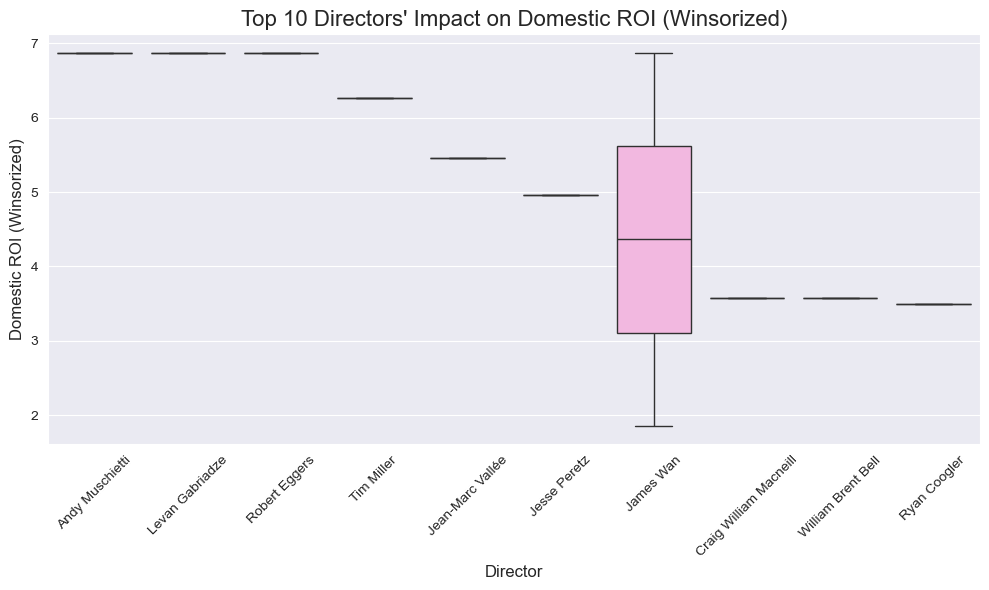

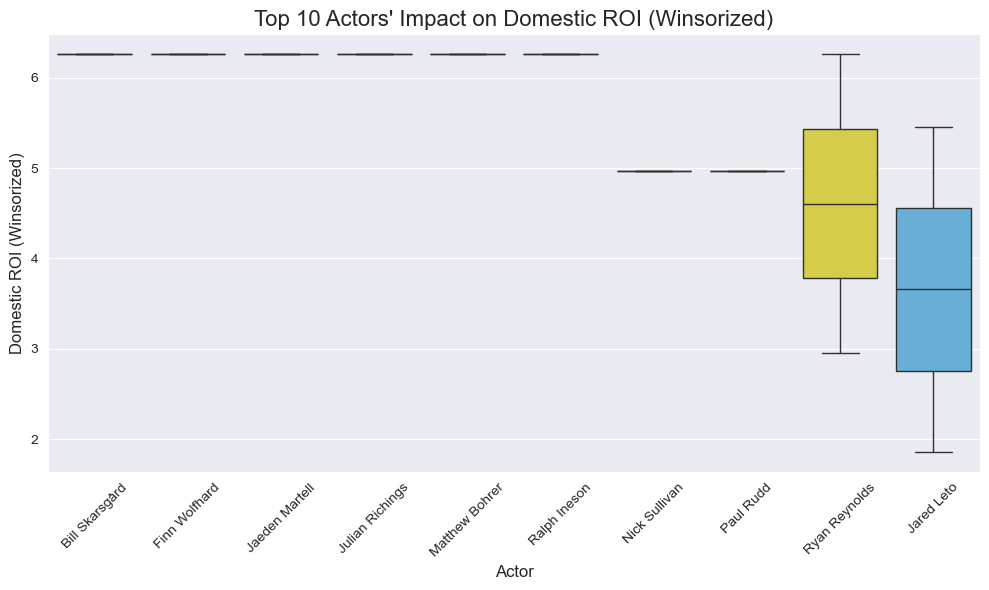

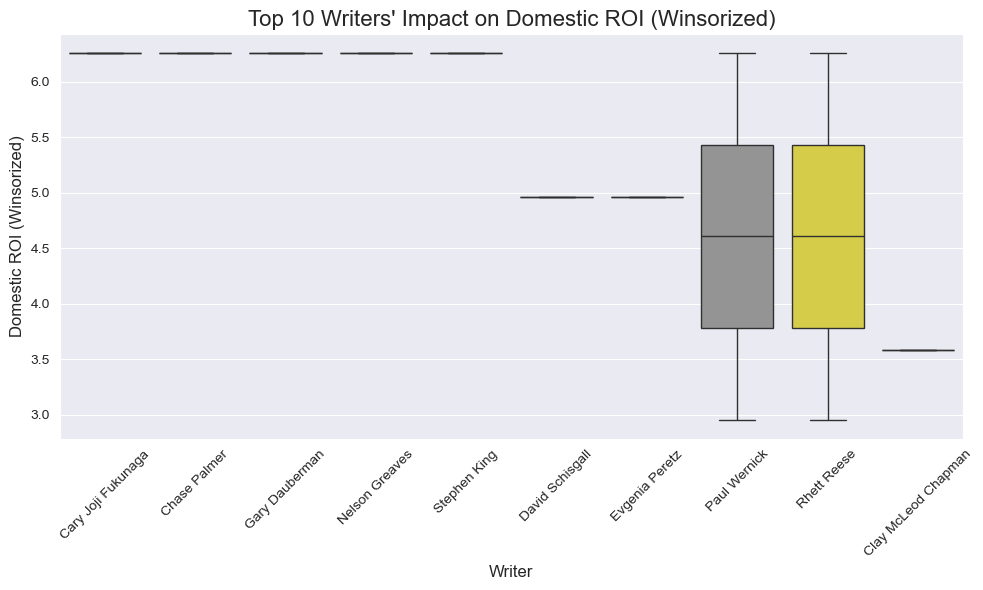

In [163]:
# Set a colorblind-friendly palette
sns.set_palette('colorblind')

# Limit to top 10 directors by mean domestic ROI
top_10_directors = top_directors_data.groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).head(10).index
director_order = top_directors_data[top_directors_data['primary_name'].isin(top_10_directors)].groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).index

# Create a figure and axis for Directors' Domestic ROI (Top 10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x=top_directors_data[top_directors_data['primary_name'].isin(top_10_directors)]['primary_name'],
            y=top_directors_data[top_directors_data['primary_name'].isin(top_10_directors)]['roi_domestic_winsorized'],
            ax=ax, order=director_order, palette="colorblind")

ax.set_title("Top 10 Directors' Impact on Domestic ROI (Winsorized)", fontsize=16)
ax.set_xlabel('Director', fontsize=12)
ax.set_ylabel('Domestic ROI (Winsorized)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Limit to top 10 actors by mean domestic ROI
top_10_actors = top_actors_data.groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).head(10).index
actor_order = top_actors_data[top_actors_data['primary_name'].isin(top_10_actors)].groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).index

# Create a figure and axis for Actors' Domestic ROI (Top 10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x=top_actors_data[top_actors_data['primary_name'].isin(top_10_actors)]['primary_name'],
            y=top_actors_data[top_actors_data['primary_name'].isin(top_10_actors)]['roi_domestic_winsorized'],
            ax=ax, order=actor_order, palette="colorblind")

ax.set_title("Top 10 Actors' Impact on Domestic ROI (Winsorized)", fontsize=16)
ax.set_xlabel('Actor', fontsize=12)
ax.set_ylabel('Domestic ROI (Winsorized)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Limit to top 10 writers by mean domestic ROI
top_10_writers = top_writers_data.groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).head(10).index
writer_order = top_writers_data[top_writers_data['primary_name'].isin(top_10_writers)].groupby('primary_name')['roi_domestic_winsorized'].mean().sort_values(ascending=False).index

# Create a figure and axis for Writers' Domestic ROI (Top 10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x=top_writers_data[top_writers_data['primary_name'].isin(top_10_writers)]['primary_name'],
            y=top_writers_data[top_writers_data['primary_name'].isin(top_10_writers)]['roi_domestic_winsorized'],
            ax=ax, order=writer_order, palette="colorblind")

ax.set_title("Top 10 Writers' Impact on Domestic ROI (Winsorized)", fontsize=16)
ax.set_xlabel('Writer', fontsize=12)
ax.set_ylabel('Domestic ROI (Winsorized)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary

From the analysis, we can conclude the following:
1. **Genre** and **franchise** significantly impact both **domestic and worldwide ROI**.
2. **Release month** does not seem to have a significant impact on ROI.
3. **Production budget** has a **positive impact** on gross revenue but a minimal effect on ROI.
4. The **choice of director** plays a **significant role** in **worldwide ROI**, but there is **no significant difference** in **domestic ROI** based on the director.
5. The **choice of actor** and **writer** has a **significant impact** on both **domestic and worldwide ROI**, with different performers contributing to the financial success of a movie.


## Deployment: Recommendations for Stakeholders

Based on the analysis of genre, franchise involvement, budget, and the impact of directors, actors, and writers on ROI, I recommend the following three types of movies for our company to focus on to maximize financial success:

#### 1. Focus on Horror, Animation, and Thriller Genres
Horror movies, in particular, show the highest ROI both domestically and worldwide. Following horror, animation, and thriller genres also tend to perform well in terms of ROI. These genres consistently outperform others due to their ability to attract wide audiences, often with lower production costs. For instance, horror movies tend to have a relatively lower production budget while still drawing large crowds, making them a high-reward choice. By focusing on these genres, our company can optimize ROI while minimizing risk.

#### 2. Leverage Franchises for Consistent Returns
Movies that are part of larger franchises, such as *Star Wars*, *Fast and the Furious*, *Marvel*, and *Harry Potter*, consistently deliver higher ROI both domestically and worldwide. Audiences are already invested in these storylines and characters, making franchise movies a safer financial bet. Our company should consider either creating sequels within an existing franchise or developing new series that can grow into a franchise. This long-term strategy will ensure sustained financial success.

#### 3. Invest in High-ROI Talent: Actors and Writers
While higher budgets don't necessarily guarantee higher ROI, choosing the right talent does. Actors like **Julian Richings**, **Bill Skarsgard**, and **Finn Wolfhard** have shown significant impact on movie ROI. Writers such as **Gary Dauberman**, **Stephen King**, and **Rhett Reese** are also key contributors to financial success. Partnering with these proven talents can lead to better audience engagement and ultimately higher returns. It's important to allocate resources to hire top actors and writers who have consistently delivered strong financial results.

By focusing on these strategies—selecting high-ROI genres, leveraging franchises, and investing in talented actors and writers—our company can maximize its financial success and deliver significant value to stakeholders.
